<a href="https://colab.research.google.com/github/william-sharp/cs_216_project/blob/main/CS216_Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CS-216 Final Project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)


url1 = "https://raw.githubusercontent.com/william-sharp/cs_216_project/refs/heads/main/fishing-industry-by-country-2024.json"
fish_industry_df = pd.read_json(url1)

url2 = "https://raw.githubusercontent.com/william-sharp/cs_216_project/refs/heads/main/fisheries_support_estimate.csv"
fish_support_estimate = pd.read_csv(url2)

url3 = "https://raw.githubusercontent.com/william-sharp/cs_216_project/refs/heads/main/travel_and_tourism_index_csv.csv"
tandt_index = pd.read_csv(url3, encoding = "ISO-8859-1", header = [0,1])
# Loop through the columns and join top and bottom column names if applicable
new_columns = []
for col in tandt_index.columns:
    top_level = col[0]
    bottom_level = col[1]
    new_columns.append(f"{top_level} - {bottom_level}" if "Unnamed" not in top_level else bottom_level)
tandt_index.columns = new_columns


url4 = "https://raw.githubusercontent.com/william-sharp/cs_216_project/refs/heads/main/ocean_health_index_scores.csv"
ocean_health_index = pd.read_csv(url4)

url5 = "https://raw.githubusercontent.com/william-sharp/cs_216_project/refs/heads/main/sustainable_fisheries_as_proportion_of_gdp.csv"
sust_fish_prop_gpd = pd.read_csv(url5)

url6 = "https://raw.githubusercontent.com/william-sharp/cs_216_project/refs/heads/main/employment_in_fisheries.csv"
employment_fish = pd.read_csv(url6)

In [2]:
#Filter to get useful columns from fishing industry dataset
filtered_fish_industry_df = fish_industry_df[[column for column in fish_industry_df.columns if "2021" in column or column == "country"]]

#Filter to get useful columns from the estimated fishery support dataset
filtered_fish_support_estimate = fish_support_estimate[[column for column in fish_support_estimate.columns if column in [ "Country", "Variable", "Measure", "TIME_PERIOD", "OBS_VALUE" ]]]
filtered_fish_support_estimate = filtered_fish_support_estimate[filtered_fish_support_estimate["Measure"] == "US dollar"]
filtered_fish_support_estimate = filtered_fish_support_estimate.drop(columns=['Measure'])

#Filter to get useful columns from travel and tourism dataset
filtered_tandt_index = tandt_index[[column for column in tandt_index.columns if "2021" in column or column in ["Economy"]]]

#Filter to get useful columns and rows from ocean_health_index

ohi_index_mask = ocean_health_index["long_goal"].isin(["Mariculture (subgoal)", "Tourism & recreation", "Fisheries (subgoal)"])
ocean_health_index = ocean_health_index[ohi_index_mask]
ohi_index_mask_timeframe = ocean_health_index["dimension"].isin(["score"])
ocean_health_index = ocean_health_index[ohi_index_mask_timeframe]
filtered_ocean_health_index = ocean_health_index[[column for column in ocean_health_index.columns if column in ["scenario", "long_goal", "region_name", "value"]]]

#Filter to get useful columns from the sustainable fisheries as a proportion of GDP dataset
filtered_sust_fish_prop_gpd = sust_fish_prop_gpd[[column for column in sust_fish_prop_gpd.columns if column in ["Area", "TIME_PERIOD", "OBS_VALUE", ]]]

#Filter to get useful columns from fishery employment dataset
filtered_employment_fish = employment_fish[[column for column in employment_fish.columns if column in ["Reference area", "Working domain", "Sex", "Working status", "TIME_PERIOD", "OBS_VALUE"]]]


In [3]:
filtered_fish_industry_df = filtered_fish_industry_df.rename(columns={"country": "Country", "FishingIndustry_TotalFisheriesProduction_tonnes_2021":"Total Fishery Production (tonnes)","FishingIndustry_CaptureFisheriesProduction_tonnes_2021":"Capture Fishery Production (tonnes)","FishingIndustry_AquacultureProduction_tonnes_2021":"Aquaculture Production (tonnes)"})
filtered_fish_support_estimate = filtered_fish_support_estimate.rename(columns={"TIME_PERIOD" : "Year", "OBS_VALUE": "Estimated Fishery Support (USD)", "Variable":"Support Type"})
filtered_tandt_index = filtered_tandt_index.rename(columns={"Economy": "Country"})
filtered_ocean_health_index = filtered_ocean_health_index.rename(columns={"region_name": "Country", "scenario":"Year", "value":"OHI Score", "long_goal":"OHI Goal"})
filtered_sust_fish_prop_gpd = filtered_sust_fish_prop_gpd.rename(columns={"Area": "Country", "TIME_PERIOD" : "Year", "OBS_VALUE": "Sustainable Fisheries as Proportion of GDP"})

filtered_employment_fish = filtered_employment_fish.rename(columns={"Reference area": "Country", "TIME_PERIOD" : "Year", "OBS_VALUE": "People Employed"})

In [4]:
#filter all dataframes to use 2021 or 2020 data - most recent

filtered_fish_support_estimate = filtered_fish_support_estimate[filtered_fish_support_estimate["Year"] == 2020]
filtered_fish_support_estimate = filtered_fish_support_estimate[filtered_fish_support_estimate["Support Type"].isin(["I.A. Transfers based on input use"])]

ohi_index_mask_2 = filtered_ocean_health_index["Year"].isin([2021])
filtered_ocean_health_index = filtered_ocean_health_index[ohi_index_mask_2]

filtered_sust_fish_prop_gpd = filtered_sust_fish_prop_gpd[filtered_sust_fish_prop_gpd["Year"] == 2021]


filtered_employment_fish = filtered_employment_fish[filtered_employment_fish["Year"] == 2021]
filtered_employment_fish = filtered_employment_fish[filtered_employment_fish["Sex"] == "Total"]
filtered_employment_fish = filtered_employment_fish[filtered_employment_fish["Working status"] == "Total"]

filtered_employment_fish = filtered_employment_fish[filtered_employment_fish["Working domain"].isin(["Aquaculture","Fishing sector"])]



In [5]:
#Delete year columns to not run into suffix errors
filtered_fish_support_estimate = filtered_fish_support_estimate.drop(columns=['Year'])
filtered_ocean_health_index = filtered_ocean_health_index.drop(columns=['Year'])
filtered_sust_fish_prop_gpd = filtered_sust_fish_prop_gpd.drop(columns=['Year'])
filtered_employment_fish = filtered_employment_fish.drop(columns=['Year', 'Sex','Working status'])

In [6]:
# Perform inner joins step-by-step to ensure one row per Country-Year

merged_df = filtered_fish_industry_df.merge(filtered_fish_support_estimate, on="Country", how="outer")
merged_df = merged_df.merge(filtered_tandt_index, on="Country", how="outer")
merged_df = merged_df.merge(filtered_ocean_health_index, on="Country", how="right")
merged_df = merged_df.merge(filtered_sust_fish_prop_gpd, on="Country", how="left")
merged_df = merged_df.merge(filtered_employment_fish, on="Country", how="left")

pivot_df = merged_df.pivot_table(index='Country', columns='Working domain', values='People Employed', aggfunc='mean', fill_value=0)
pivot_df.reset_index(inplace=True)
merged_df = merged_df.merge(pivot_df, on="Country", how="left")
merged_df = merged_df.drop(columns=['Working domain', 'People Employed'])
merged_df = merged_df.rename(columns = {"Aquaculture": "Persons Employed in Aquaculture", "Fishing sector":"Persons Employed in Fishing sector"})



merged_df



,Country,Total Fishery Production (tonnes),Capture Fishery Production (tonnes),Aquaculture Production (tonnes),Support Type,Estimated Fishery Support (USD),Travel & Tourism Development Index - 2021 Value,Travel & Tourism Development Index - 2021 Rank,Enabling Environment subindex - 2021 Value,Enabling Environment subindex - 2021 Rank,Travel and Tourism Policy and Enabling\nConditions subindex - 2021 Value,Travel and Tourism Policy and Enabling\nConditions subindex - 2021 Rank,Infrastructure subindex - 2021 Value,Infrastructure subindex - 2021 Rank,Travel and Tourism Demand Drivers\nsubindex - 2021 Value,Travel and Tourism Demand Drivers\nsubindex - 2021 Rank,Travel and Tourism Sustainability subindex - 2021 Value,2021 Rank,Business Environment pillar - 2021 Value,Business Environment pillar - 2021 Rank,Safety and Security pillar - 2021 Value,Safety and Security pillar - 2021 Rank,Health and Hygiene pillar - 2021 Value,Health and Hygiene pillar - 2021 Rank,Human Resources and Labour Market pillar - 2021 Value,Human Resources and Labour Market pillar - 2021 Rank,ICT Readiness pillar - 2021 Value,ICT Readiness pillar - 2021 Rank,Prioritization of Travel & Tourism pillar - 2021 Value,Prioritization of Travel & Tourism pillar - 2021 Rank,International Openness pillar - 2021 Value,International Openness pillar - 2021 Rank,Price competitiveness pillar - 2021 Value,Price competitiveness pillar - 2021 Rank,Air Transport Infrastructure pillar - 2021 Value,Air Transport Infrastructure pillar - 2021 Rank,Ground and Port Infrastructure pillar - 2021 Value,Ground and Port Infrastructure pillar - 2021 Rank,Tourist Service Infrastructure pillar - 2021 Value,Tourist Service Infrastructure pillar - 2021 Rank,Natural Resources pillar - 2021 Value,Natural Resources pillar - 2021 Rank,Cultural Resources pillar - 2021 Value,Cultural Resources pillar - 2021 Rank,Non-Leisure Resources pillar - 2021 Value,Non-Leisure Resources pillar - 2021 Rank,Environmental Sustainability pillar - 2021 Value,Environmental Sustainability pillar - 2021 Rank,Socioeconomic Resilience & Conditions pillar - 2021 Value,Socioeconomic Resilience & Conditions pillar - 2021 Rank,T&T Demand Pressure & Impact pillar - 2021 Value,T&T Demand Pressure & Impact pillar - 2021 Rank,OHI Goal,OHI Score,Sustainable Fisheries as Proportion of GDP,Persons Employed in Aquaculture,Persons Employed in Fishing sector
0,Global average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fisheries (subgoal),54.71,NaN,NaN,NaN
1,Cocos Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fisheries (subgoal),77.20,NaN,NaN,NaN
2,Christmas Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fisheries (subgoal),39.42,NaN,NaN,NaN
3,Norfolk Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fisheries (subgoal),8.14,NaN,NaN,NaN
4,Macquarie Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fisheries (subgoal),92.90,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,Bonaire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

R squared for model to predict tourism OHI:  0.013499535462077605


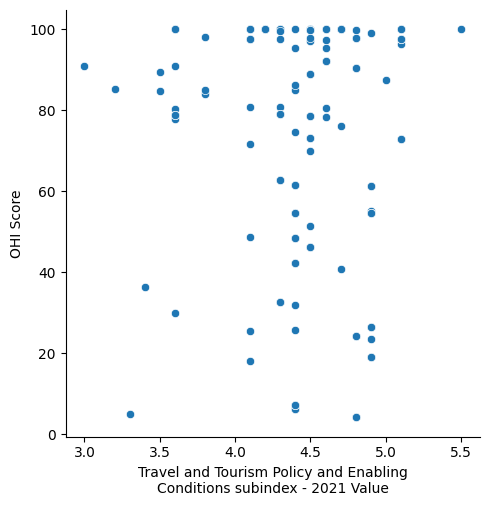

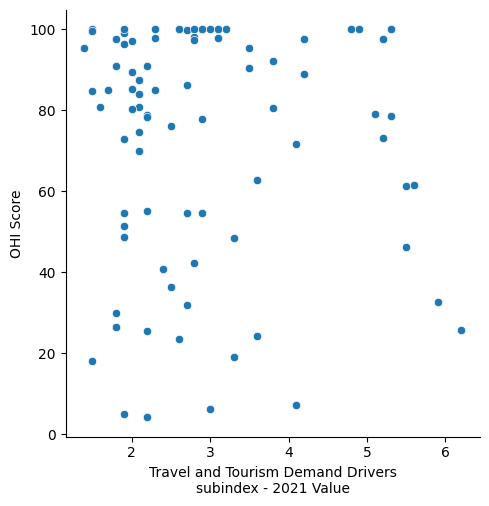

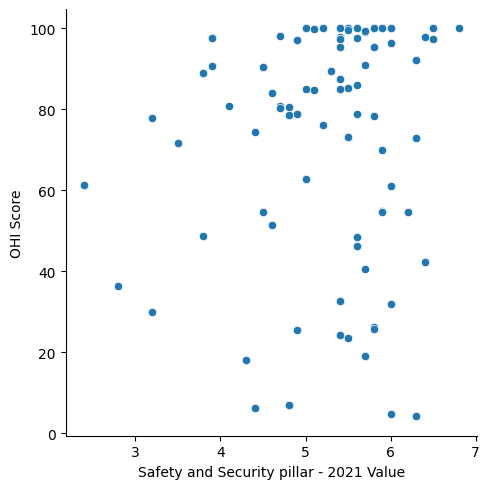

In [7]:
#Andrews
tourism_OHI =  merged_df[merged_df['OHI Goal'] == 'Tourism & recreation']
tourism_OHI = tourism_OHI.dropna(subset=['OHI Goal', 'OHI Score', 'Travel and Tourism Policy and Enabling\nConditions subindex - 2021 Value', 'Travel and Tourism Demand Drivers\nsubindex - 2021 Value', 'Safety and Security pillar - 2021 Value'])

sns.relplot(data = tourism_OHI, x = 'Travel and Tourism Policy and Enabling\nConditions subindex - 2021 Value', y = 'OHI Score')

sns.relplot(data = tourism_OHI, x = 'Travel and Tourism Demand Drivers\nsubindex - 2021 Value', y = 'OHI Score')

sns.relplot(data = tourism_OHI, x = 'Safety and Security pillar - 2021 Value', y = 'OHI Score')

#Pull data into values
data_tourism_predictors = tourism_OHI[['Travel and Tourism Policy and Enabling\nConditions subindex - 2021 Value', 'Travel and Tourism Demand Drivers\nsubindex - 2021 Value', 'Safety and Security pillar - 2021 Value']].values
target_tourism = tourism_OHI['OHI Score'].values

#Regression
linear_model_tourism = LinearRegression()
linear_model_tourism.fit(X = data_tourism_predictors, y = target_tourism)

#Prediction
predicted_tourism_OHI = linear_model_tourism.predict(data_tourism_predictors)

#R^2 for model
print('R squared for model to predict tourism OHI: ', r2_score(target_tourism, predicted_tourism_OHI))

R squared for model to predict fisheries OHI:  0.070236898863969


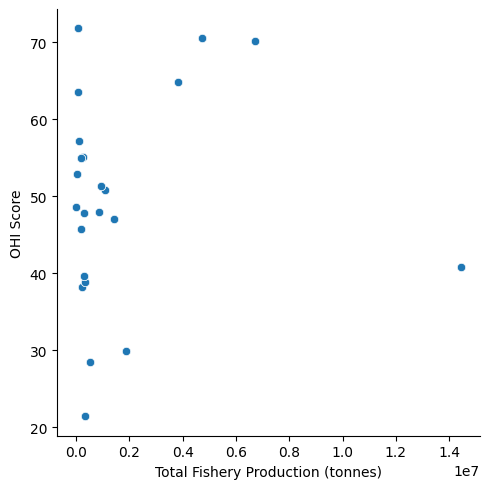

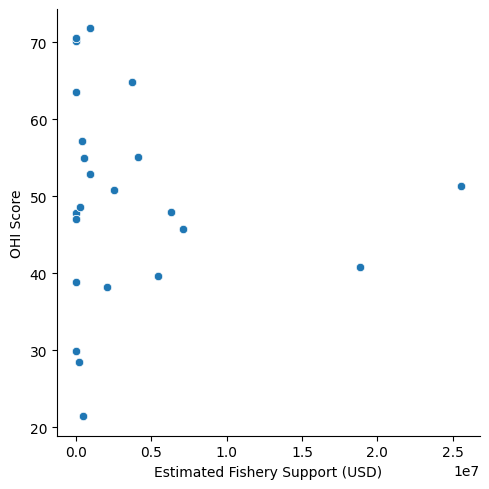

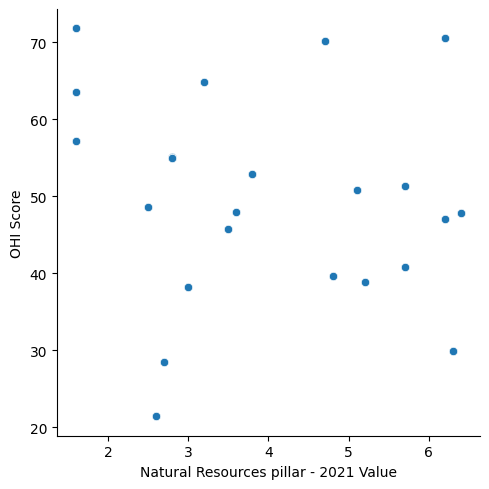

In [8]:
#Jerry


#Filter for only the Fisheries subgoal and take out NAs to prepare df for regression
fisheries_OHI =  merged_df[merged_df['OHI Goal'] == 'Fisheries (subgoal)']
fisheries_OHI = fisheries_OHI.dropna(subset=['OHI Goal', 'Total Fishery Production (tonnes)', 'Estimated Fishery Support (USD)', 'Natural Resources pillar - 2021 Value'])


#Visualizing the three different predictors against OHI score for Fisheries
sns.relplot(data = fisheries_OHI, x = 'Total Fishery Production (tonnes)', y = 'OHI Score')

sns.relplot(data = fisheries_OHI, x = 'Estimated Fishery Support (USD)', y = 'OHI Score')

sns.relplot(data = fisheries_OHI, x = 'Natural Resources pillar - 2021 Value', y = 'OHI Score')

#Pull data into values
data_fisheries_predictors = fisheries_OHI[['Total Fishery Production (tonnes)', 'Estimated Fishery Support (USD)', 'Natural Resources pillar - 2021 Value']].values
target_fisheries = fisheries_OHI['OHI Score'].values

#Regression
linear_model_fisheries = LinearRegression()
linear_model_fisheries.fit(X = data_fisheries_predictors, y = target_fisheries)

#Prediction
predicted_fisheries_OHI = linear_model_fisheries.predict(data_fisheries_predictors)

#R^2 for model
print('R squared for model to predict fisheries OHI: ', r2_score(target_fisheries, predicted_fisheries_OHI))

R squared for model to predict mariculture OHI:  0.07825773132220937


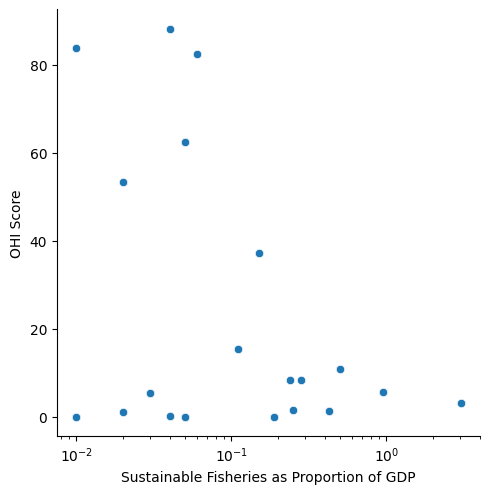

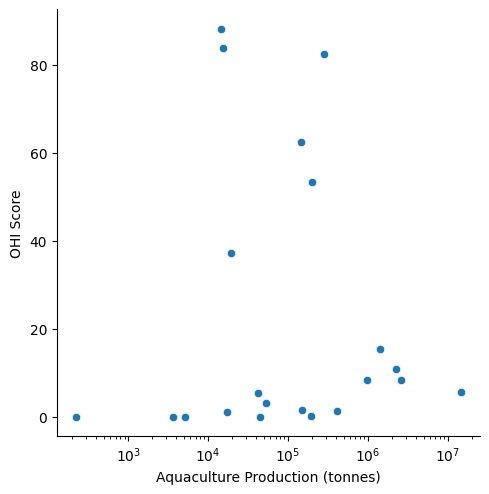

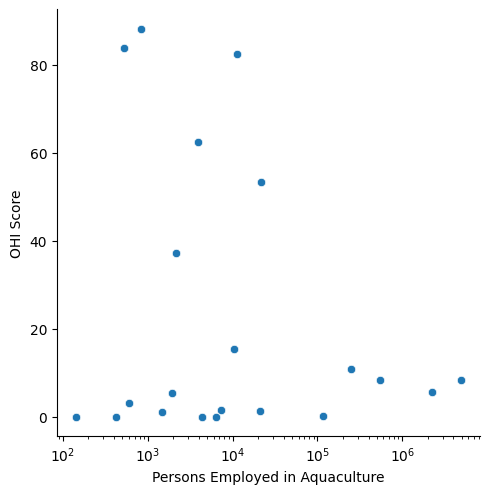

In [9]:
#Oliver

mar_data = merged_df.copy()
mar_data = mar_data[mar_data['OHI Goal'] == 'Mariculture (subgoal)']
mar_data = mar_data.dropna(subset=['OHI Score'])  # Drop rows with NA in 'OHI Score'
mar_data = mar_data.dropna(subset=['Sustainable Fisheries as Proportion of GDP'])  # Drop rows with NA in 'OHI Score'
mar_data = mar_data.dropna(subset=['Aquaculture Production (tonnes)'])  # Drop rows with NA in 'OHI Score'
mar_data = mar_data.dropna(subset=['Persons Employed in Aquaculture'])  # Drop rows with NA in 'OHI Score'

#print(mar_data)


plt1 = sns.relplot(data = mar_data, x = 'Sustainable Fisheries as Proportion of GDP', y = 'OHI Score',)
plt1.set(xscale="log")

plt2 = sns.relplot(data = mar_data, x = 'Aquaculture Production (tonnes)', y = 'OHI Score')
plt2.set(xscale="log")

plt3 = sns.relplot(data = mar_data, x = 'Persons Employed in Aquaculture', y = 'OHI Score')
plt3.set(xscale="log")

#Pull data into values
data_mar_predictors = mar_data[['Sustainable Fisheries as Proportion of GDP', 'Aquaculture Production (tonnes)', 'Persons Employed in Aquaculture']].values
target_mar = mar_data['OHI Score'].values

#Regression
linear_model_mar = LinearRegression()
linear_model_mar.fit(X = data_mar_predictors, y = target_mar)

#Prediction
predicted_mar_OHI = linear_model_mar.predict(data_mar_predictors)

#R^2 for model
print('R squared for model to predict mariculture OHI: ', r2_score(target_mar, predicted_mar_OHI))

In [10]:
#will
